In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

In [138]:
# read the early g-band data
fp = h5py.File("../data/lc/iPTF16abcLightCurve.h5")
dataset = fp["/LightCurve"]

In [139]:
idx = np.logical_and.reduce([dataset["JD"] < 2457500, dataset["filterName"] == "g", dataset["source"] == "P48+CFH12k"])
tbl = dataset[idx]

In [140]:
print tbl

[(2457479.8474, 'g', nan, nan, 21.88, 'P48+CFH12k')
 (2457479.87647, 'g', nan, nan, 21.55, 'P48+CFH12k')
 (2457479.9056, 'g', nan, nan, 21.27, 'P48+CFH12k')
 (2457480.85815, 'g', nan, nan, 21.9, 'P48+CFH12k')
 (2457480.88736, 'g', nan, nan, 22.11, 'P48+CFH12k')
 (2457480.9155, 'g', nan, nan, 22.07, 'P48+CFH12k')
 (2457481.85904, 'g', 21.35, 0.12, 22.08, 'P48+CFH12k')
 (2457481.88771, 'g', 21.26, 0.13, 21.86, 'P48+CFH12k')
 (2457482.84597, 'g', 19.26, 0.07, 20.97, 'P48+CFH12k')
 (2457482.87483, 'g', 19.33, 0.05, 21.35, 'P48+CFH12k')
 (2457482.90359, 'g', 19.28, 0.04, 21.6, 'P48+CFH12k')
 (2457483.84625, 'g', 18.78, 0.04, 21.16, 'P48+CFH12k')
 (2457483.87501, 'g', 18.73, 0.04, 21.23, 'P48+CFH12k')
 (2457483.90389, 'g', 18.64, 0.04, 21.22, 'P48+CFH12k')
 (2457484.8458, 'g', 18.25, 0.05, 20.61, 'P48+CFH12k')
 (2457484.87462, 'g', 18.21, 0.05, 20.35, 'P48+CFH12k')
 (2457484.90328, 'g', 18.29, 0.05, 20.47, 'P48+CFH12k')
 (2457492.87052, 'g', 16.13, 0.04, 18.98, 'P48+CFH12k')
 (2457492.8991, 

(23.0, 16.0)

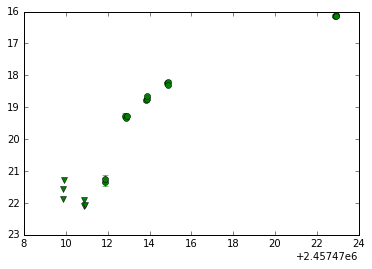

In [141]:
idx = np.isnan(tbl["mag"])
plt.plot(tbl["JD"][idx], tbl["magLimit"][idx], marker="v", color="g", linestyle="none")
idx = ~idx
plt.errorbar(tbl["JD"][idx], tbl["mag"][idx], yerr=tbl["magErr"][idx], marker='o', color='g', linestyle='none')
plt.ylim(plt.ylim()[::-1])

4753.79648641
-1537.19014274


(-0.1, 1.1)

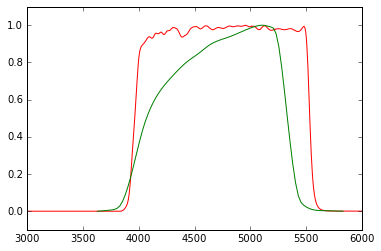

In [5]:
# compare the PTF g-band and SDSS g-band
arr = np.genfromtxt("../data/PTFg.txt", names=["wavelength", "trans"])
arr["wavelength"] *= 10
plt.plot(arr["wavelength"], arr["trans"]/arr["trans"].max(), "r")

arr["trans"] /= arr["trans"].max()
print(np.sum(arr["wavelength"] * arr["trans"]) / np.sum(arr["trans"]))
f = arr["wavelength"] * arr["trans"]
print(np.sum((arr["trans"][:-1] + arr["trans"][1:]) * (arr["wavelength"][1:] - arr["wavelength"][:-1])) / 2)

arr = np.genfromtxt("../data/SDSSg.txt", usecols=(0,1), names=["wavelength", "trans"])
plt.plot(arr["wavelength"], arr["trans"]/arr["trans"].max(), "g")

plt.xlim(3000, 6000)
plt.ylim(-0.1, 1.1)

In [143]:
import phys
def RW11(t, R=1e10, E=1e51, M=1.4*phys.sm, kappa=0.2, fp=0.05):
    L = 9.9e42 * (R/1e13) * (E/1e51)**0.85 * (M/phys.sm)**(-0.69) *\
        (kappa/0.34)**(-0.85) * fp**(-0.16) * (t*86400/1e5)**(-0.31)
    T = 1.6*phys.eV/phys.k * (R/1e13)**0.25 * (E/1e51)**0.016 * (M/phys.sm)**(-0.033) *\
        (kappa/0.34)**(-0.27) / fp**0.022 * (t*86400/1e5)**(-0.47)
    return L, T

def PCW10(t, E=1e51, R=0.01*phys.sr, M=1.4*phys.sm, mu=2.):
    g = phys.ggrav*M/(R*R)
    K = 9.91e12/mu**(5./3)
    Vrun = 0.79 * (E/M)**0.5
    rhorun = M / R**3
    print g/1e9, K/1e13, Vrun/1e9, rhorun/1e6, R/10**8.5
    L = 2e40 * ((g/1e9)/(K/1e13))**(-0.41) * (Vrun/1e9)**1.9 * (rhorun/1e6)**0.36 *\
        (R/10**8.5)**0.83 * (t*86400/1e4)**(-0.16) * 7**(-4./3)
    T = 2e4 * ((g/1e9)/(K/1e13))**(-0.058) * (Vrun/1e9)**0.03 * (rhorun/1e6)**0.0058 *\
        (R/10**8.5)**0.11 * (t*86400/1e4)**(-0.44) * 7**(-1./3)
    return L, T

def Planck(T, wv):
    return 2*phys.h*phys.c*phys.c / (wv**5) / (np.exp(phys.h*phys.c/(wv*phys.k*T)) - 1)

def Lnu(t, R, D, model="RW11"):
    if model == "RW11":
        L, T = RW11(t, R=R)
    elif model == "PCW10":
        L, T = PCW10(t, R=R)
    filterCurve = np.genfromtxt("../data/PTFg.txt", names=["wavelength", "trans"])
    wavelength = filterCurve["wavelength"][::-1]*1e-7 # cm
    transmission = filterCurve["trans"][::-1]
    wavelengthEffective = np.sum(wavelength*transmission) / np.sum(transmission)
    flux = np.zeros(L.shape)
    for i in range(len(L)):
        flux[i] = L[i]/(4.*np.pi*D*D) * np.pi *\
                  np.sum(Planck(T[i], wavelength)*wavelength*transmission) /\
                  np.sum(wavelength*transmission) / (phys.sigma*T[i]**4) *\
                  wavelengthEffective * wavelengthEffective / phys.c * 1e26 # mJy
    mag = -2.5 * np.log10(flux/3631e3)
    return flux, mag

Explosion date: 1.24+/-0.05
Power law index: 1.56+/-0.03
First detection date: 0.62


/Users/ycao/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in power


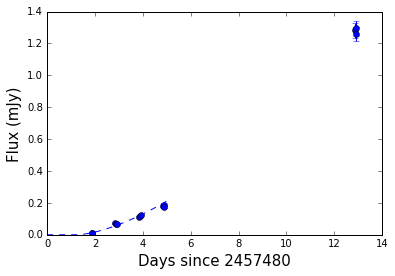

In [147]:
idx = ~np.isnan(tbl["mag"])
t = tbl["JD"][idx] - 2457480
flux = 3631e3*10**(-tbl["mag"][idx]/2.5) # mJy
fluxErr = tbl["magErr"][idx] / 1.0857 * flux
idx = t < 16
t = t[idx]
flux = flux[idx]
fluxErr = fluxErr[idx]
plt.errorbar(t, flux, yerr=fluxErr, marker='o', linestyle='none')


# fit a power law
def powerLaw(tExp, t0, beta, C):
    return np.where(tExp > t0, C*(tExp-t0)**beta, 0)

from scipy.optimize import curve_fit
p0 = (1.68, 0.97, 0.06)
popt, pcov = curve_fit(powerLaw, t, flux, p0=p0, sigma=fluxErr, absolute_sigma=True)
print "Explosion date: %.2f+/-%.2f" % (popt[0], pcov[0][0]**0.5)
print "Power law index: %.2f+/-%.2f" % (popt[1], pcov[1][1]**0.5)
print "First detection date: %.2f" % (t[0] - popt[0])
tExp = np.linspace(0., 5.0, 501)
plt.plot(tExp, powerLaw(tExp, *popt), color='b', linestyle='--')
plt.xlabel("Days since 2457480", fontsize=15)
plt.ylabel("Flux (mJy)", fontsize=15)

t = t - popt[0] # new t

3.84101074617e-05 0.312145440111 0.473428519018 8.27663775195e-06 219.936411265


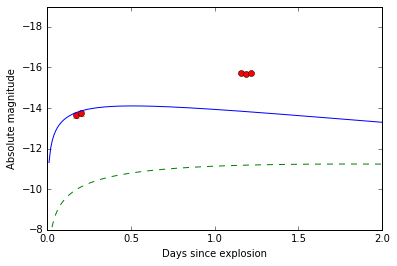

In [145]:
D = 100*phys.Mpc
dSTD = 10*phys.pc
mu = 35.
plt.errorbar(t, -2.5*np.log10(flux*D**2/dSTD**2/3631e3), 
             yerr=1.0857*fluxErr/flux, marker='o', color="r", linestyle='none')
plt.ylim(plt.ylim()[::-1])

tExp = np.linspace(0.01, 5, 500)
tFlux, mag = Lnu(tExp, phys.sr, dSTD)
plt.plot(tExp, mag, 'b-')
tFlux, mag = Lnu(tExp, phys.sr, dSTD, model="PCW10")
plt.plot(tExp, mag, 'g--')

plt.xlim(0,2)
plt.ylim(-8, -19)

plt.xlabel("Days since explosion")
plt.ylabel("Absolute magnitude")

In [29]:
tExp = np.linspace(0.1,3,30)
L, T = PCW10(tExp, R=phys.sr)
print L, T
L, T = RW11(tExp, R=phys.sr)
print L, T

3.84101074617e-05 0.312145440111 0.473428519018 8.27663775195e-06 219.936411265
[  1.92739863e+40   1.72507010e+40   1.61671008e+40   1.54398099e+40
   1.48982873e+40   1.44699605e+40   1.41174371e+40   1.38190169e+40
   1.35610321e+40   1.33343407e+40   1.31325396e+40   1.29509775e+40
   1.27861740e+40   1.26354601e+40   1.24967461e+40   1.23683666e+40
   1.22489742e+40   1.21374638e+40   1.20329184e+40   1.19345692e+40
   1.18417656e+40   1.17539521e+40   1.16706513e+40   1.15914495e+40
   1.15159865e+40   1.14439463e+40   1.13750508e+40   1.13090536e+40
   1.12457356e+40   1.11849010e+40] [ 31079.45094525  22909.73890945  19166.3752079   16887.56142519
  15308.28489149  14128.19848803  13201.71035972  12448.40598213
  11819.70489946  11284.26659252  10820.82955835  10414.38406334
  10053.98569252   9731.43759947   9440.46059683   9176.1508719
   8934.61436919   8712.71354537   8507.88779143   8318.02343853
   8141.35792123   7976.40796171   7821.91496083   7676.80292081
   7540.1456

In [107]:
import datetime
import astro

## Swift data
tbl = []
with open("../data/lc/swiftRawData.txt", "r") as fp:
    for row in fp:
        if row.startswith("#"):
            continue
        if len(row[:-1].strip()) == 0:
            continue
        tmp = row[:-1].split("\t")
        obsdate = astro.utc2jd(datetime.datetime.strptime(tmp[1].split(".")[0], "%Y-%m-%d %H:%M:%S"))
        mag = float(tmp[10])
        magErr = float(tmp[0])
        filterName = tmp[8].strip()
        fluxLambda = float(tmp[11])
        fluxLambdaErr = float(tmp[9])
        tbl.append((obsdate, mag, magErr, fluxLambda, fluxLambdaErr, filterName))
UVOTData = tbl[:]

In [108]:
t0 = popt[0] + 2457480 # explosion date

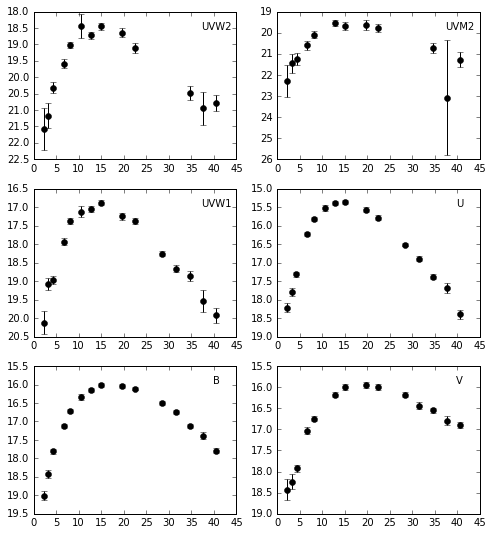

In [109]:
fig = plt.figure(figsize=(8, 9))
filterWheel = ['UVW2', 'UVM2', 'UVW1', 'U', 'B', 'V']
axDict = {}
for i, filterName in enumerate(filterWheel):
    axDict[filterWheel[i]] = fig.add_subplot(3, 2, i+1)

for obsdate, mag, magErr, fluxLambda, fluxLambdaErr, filterName in UVOTData:
    axDict[filterName].errorbar(obsdate - t0, mag, yerr=magErr, marker='o', linestyle='none', color='k')
    
for filterName in filterWheel:
    axDict[filterName].set_ylim(axDict[filterName].get_ylim()[::-1])
    axDict[filterName].text(0.9, 0.9, filterName, 
                            horizontalalignment='center',
                            verticalalignment='center',
                            transform=axDict[filterName].transAxes)

In [127]:
import math
from scipy import integrate
from scipy import interpolate

def kasen(t, a, E, M, theta, kappa=1.0):
    v = 6e8 * 1.69 * ((E/1e51)/(M/(1.4*phys.sm)))**0.5 # eq (1)
    L = 1e43 * (a/1e13) * (M/(1.4*phys.sm))**(1./4) * (v/1e9)**(7./4) *\
        kappa**(-3./4) * t**(-1./2) # Eq (22)
    T = 2.5e4 * (a/1e13)**(1./4) * kappa**(-35./36) * t**(-37./72) # Eq (25)
    return L*viewEffect(theta), T
    
def viewEffect(theta):
    # from scipy import integrate
    # print integrate.quad(viewEffect, 0., math.pi)
    # 0.6688127
    return (0.5*math.cos(theta) + 0.5) * (0.14*theta*theta - 0.4*theta + 1) / 1.2674927 * 2

def fluxDensity(t, a, E, M, theta, distance, transmissionCurve):
    L, T = kasen(t, a, E, M, theta)
    flux = np.ndarray(t.shape)
    wavelength = transmissionCurve["wavelength"]
    transmission = transmissionCurve["trans"]
    wavelengthMin = wavelength.min()
    wavelengthMax = wavelength.max()
    func = lambda wv: interpolate.interp1d(wavelength, transmission)(wv) * wv
    norm, normErr = integrate.quad(func, wavelengthMin, wavelengthMax)
    transmission = transmission / norm
    for i in range(len(t)):
        func = lambda wv: Planck(T[i], wv) *\
               interpolate.interp1d(wavelength, transmission)(wv) * wv
        frac = math.pi * integrate.quad(func, wavelengthMin, wavelengthMax)[0] / (phys.sigma*T[i]**4)
        flux[i] = L[i] * frac / (4.*math.pi*distance*distance)
    return flux # erg/s/cm^2/cm

In [128]:
from scipy import integrate
print integrate.quad(viewEffect, 0., math.pi)


(2.00000000692767, 2.220446056941572e-14)


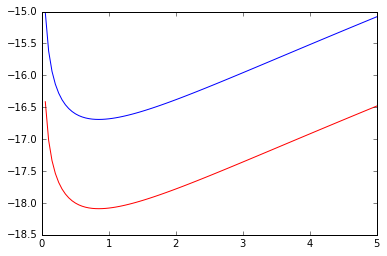

In [112]:
t = np.linspace(0.05, 5, 100)
a = 70 * phys.sr
M = 1.4 * phys.sm
E = 1e51

from astropy.io import fits
hdulist = fits.open("../data/uvotFilters/swum2_20041120v105.arf")
tbl = hdulist[1].data
transmission = np.ndarray(len(tbl), dtype=[("wavelength", "f"), ("trans", "f")])
transmission["wavelength"] = (tbl["WAVE_MIN"] + tbl["WAVE_MAX"]) / 2.*1e-8
transmission["trans"] = tbl["SPECRESP"]
effectiveWavelength = 2246e-8 # cm

flux = fluxDensity(t, a, E, M, np.pi/180*0, dSTD, transmission)
mag = -2.5*np.log10(flux*effectiveWavelength*effectiveWavelength/phys.c*1e23/3631)

plt.plot(t, mag, 'r')

flux = fluxDensity(t, a, E, M, np.pi/180*60, dSTD, transmission)
mag = -2.5*np.log10(flux*effectiveWavelength*effectiveWavelength/phys.c*1e23/3631)

plt.plot(t, mag, 'b')

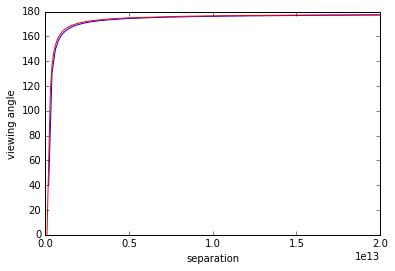

In [134]:

def findRoot(func, a, b):
    valueAtA = func(a)
    valueAtB = func(b)
    if valueAtA == 0:
        return a
    if valueAtB == 0:
        return b
    while (b - a) > 1e-3:
        c = (a + b) / 2
        valueAtC = func(c)
        if valueAtC*valueAtA > 0:
            a = c
            valueAtA = valueAtC
        else:
            b = c
            valueAtB = valueAtC
    return (a + b) / 2

for obsdate, mag, magErr, fluxLambda, fluxLambdaErr, filterName in UVOTData:
    if filterName == 'UVM2':
        break
mu = 5 * np.log10(D/(10*phys.pc))
t = np.array([obsdate - t0])

# 1 M main sequence star
M = 1.4 * phys.sm
E = 1e51
aRange = np.linspace(0.02,2,100)*1e13
thetaRange = np.zeros(aRange.shape)
for i in range(len(aRange)):
    a = aRange[i]
    flux = fluxDensity(t, a, E, M, np.pi/180*0., D, transmission) / 1e8
    frac = fluxLambda / flux
    if frac < 2.:
        func = lambda x: viewEffect(x) - frac
        theta = findRoot(func, 0., math.pi)
        thetaRange[i] = theta/math.pi * 180
    else:
        thetaRange[i] = 0.
    
plt.plot(aRange, thetaRange, 'b')

# 1 M main sequence star
M = 1 * phys.sm
E = 1e51
aRange = np.linspace(0.01,2,200)*1e13
thetaRange = np.zeros(aRange.shape)
for i in range(len(aRange)):
    a = aRange[i]
    flux = fluxDensity(t, a, E, M, np.pi/180*0., D, transmission) / 1e8
    frac = fluxLambda / flux
    if frac < 2.:
        func = lambda x: viewEffect(x) - frac
        theta = findRoot(func, 0., math.pi)
        thetaRange[i] = theta/math.pi * 180
    else:
        thetaRange[i] = 0.
    
plt.plot(aRange, thetaRange, 'r')
plt.ylim(0, 180)
plt.xlabel('separation')
plt.ylabel('viewing angle')

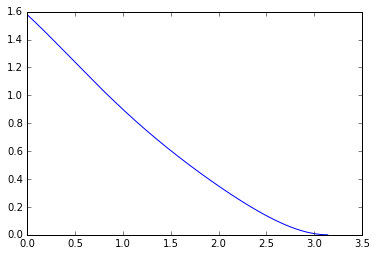

In [135]:
theta = np.linspace(0, math.pi, 200)
f = np.array(map(viewEffect, theta))
plt.plot(theta, f)